# Linear Regression

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

script_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(script_dir, '..', '..'))
input_filepath = os.path.join(project_root, 'data', 'housing.csv')

housing_data = pd.read_csv(input_filepath)
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Removing NAN

In [ ]:
print("Before : " , housing_data.isnull().sum(), "\n")

lowest_number_of_bedrooms = min(housing_data["total_bedrooms"])
print(f"lowest_number_of_bedrooms : {lowest_number_of_bedrooms}\n")

housing_data["total_bedrooms"] = housing_data["total_bedrooms"].fillna(lowest_number_of_bedrooms)

print("After " , housing_data.isnull().sum(),"")


# Removing OUTLIERS

In [ ]:
median_house_value = housing_data["median_house_value"]
Q1, Q3 = median_house_value.quantile([0.25, 0.75])
IQR = Q3 - Q1

lower_bound = max(0, Q1 - 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

print(f"📈 Housing value Statistics:")
print(f"   Q1: ₹{Q1:,.2f}, Q3: ₹{Q3:,.2f}, IQR: ₹{IQR:,.2f}")
print(f"   Bounds: [₹{lower_bound:,.2f}, ₹{upper_bound:,.2f}]")

# Step 3: Cap outliers
outliers_mask = (median_house_value < lower_bound) | (median_house_value > upper_bound)
housing_data.loc[median_house_value < lower_bound, 'median_house_value'] = lower_bound
housing_data.loc[median_house_value > upper_bound, 'median_house_value'] = upper_bound
        

# Visualizations

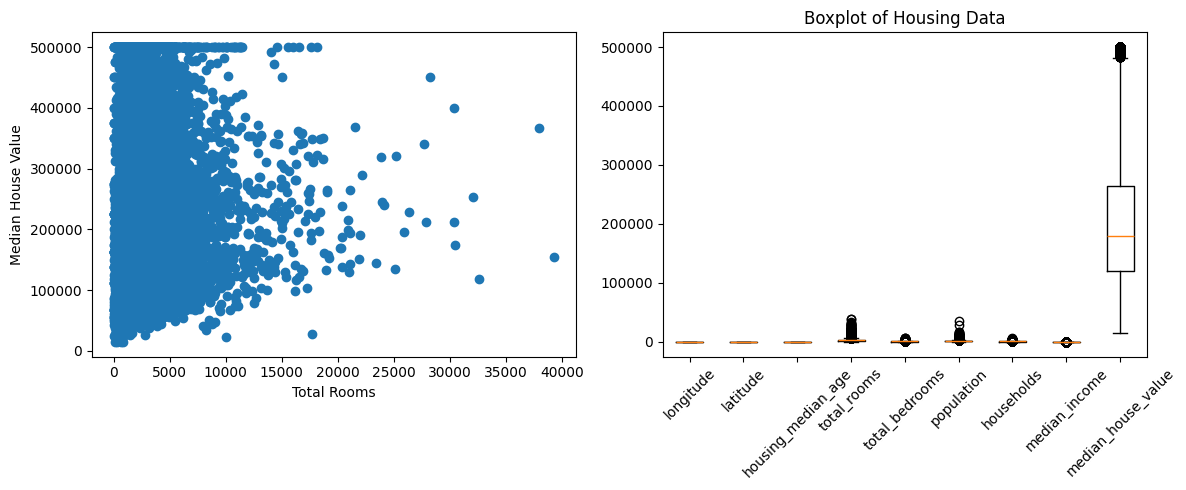

In [193]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Use axes[0,0] for plotting, not plt.scatter
axes[0].scatter(x=housing_data["total_rooms"], y=housing_data["median_house_value"])
axes[0].set_xlabel("Total Rooms")
axes[0].set_ylabel("Median House Value")


axes[1].boxplot(housing_data.select_dtypes(include=["number"]).values)
axes[1].set_xticklabels(housing_data.select_dtypes(include=["number"]).columns, rotation=45)
axes[1].set_title("Boxplot of Housing Data")

plt.tight_layout()
plt.show()

In [194]:
housing_data = housing_data.drop(housing_data.loc[housing_data["median_house_value"] == 500001].index)

In [195]:
housing_data = pd.get_dummies(housing_data, columns= ["ocean_proximity"], dtype=int)
print(housing_data.shape)
housing_data.head()

(19475, 14)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


# Modeling started

## Splitting

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Prepare features and target
X = housing_data.drop("median_house_value", axis=1)
Y = housing_data["median_house_value"]
print("X Columns:", X.columns.tolist())
print(f"Dataset shape: {housing_data.shape}")

# Split the data
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42  # Added random_state for reproducibility
)
print(f"Training set: {x_train.shape}, Testing set: {x_test.shape}")
print(f"Training target: {y_train.shape}, Testing target: {y_test.shape}")

# Handle missing values if any
if x_train.isnull().sum().any() or x_test.isnull().sum().any():
    print("Warning: Missing values detected. Handling them...")
    x_train = x_train.fillna(x_train.mean())
    x_test = x_test.fillna(x_train.mean())  # Use training stats for test set

# Scale the data properly
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)  # Important: Use transform, not fit_transform

print(f"\nScaling applied. Training set stats after scaling:")
print(f"Mean: {x_train_scaled.mean():.2f}, Std: {x_train_scaled.std():.2f}")

# Fit model
linear_model = LinearRegression()
linear_model.fit(x_train_scaled, y_train)

# Calculate scores
train_score = linear_model.score(x_train_scaled, y_train)
test_score = linear_model.score(x_test_scaled, y_test)

print(f"\nTraining R² score: {train_score:.4f}")
print(f"Testing R² score: {test_score:.4f}")

# Feature importance analysis
coef_df = pd.DataFrame({
    'feature': x_train.columns,
    'coefficient': linear_model.coef_,
    'abs_coefficient': np.abs(linear_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nFeature Coefficients (sorted by importance):")
print(coef_df)

# Make predictions
y_pred = linear_model.predict(x_test_scaled)

# Calculate additional metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:,.2f}")
print(f"Root Mean Squared Error: {rmse:,.2f}")
print(f"Mean Absolute Error: {mae:,.2f}")

# Create comprehensive prediction dataframe
prediction_df = pd.DataFrame({
    "actual": y_test.values,
    "predicted": y_pred,
    "residual": y_test.values - y_pred,
    "absolute_error": np.abs(y_test.values - y_pred)
})

# Calculate percentage error
prediction_df["percentage_error"] = (prediction_df["residual"] / prediction_df["actual"]) * 100
prediction_df["absolute_percentage_error"] = np.abs(prediction_df["percentage_error"])

print(f"\nPrediction Analysis:")
print(f"Mean Absolute Percentage Error: {prediction_df['absolute_percentage_error'].mean():.2f}%")
print(f"Max Absolute Percentage Error: {prediction_df['absolute_percentage_error'].max():.2f}%")

# Display sample predictions
print("\nSample Predictions (first 10):")
print(prediction_df.head(10).round(2))

# Additional: Model intercept
print(f"\nModel intercept: {linear_model.intercept_:.2f}")

# Optional: Check for potential overfitting
if train_score - test_score > 0.1:
    print("\nWarning: Large gap between training and testing scores suggests potential overfitting")
else:
    print("\nTraining and testing scores are consistent")


X Columns :  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'],
      dtype='object')


In [197]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(15580, 13) (3895, 13)
(15580,) (3895,)


## Model training and fitting

In [198]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Scale the data properly
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# Fit model
linear_model = LinearRegression().fit(x_train_scaled, y_train)

# Calculate score on scaled data
train_score = linear_model.score(x_train_scaled, y_train)
print("Training score with proper scaling:", train_score)

Training score with proper scaling: 0.6123785514679734


In [190]:
coef = pd.Series(linear_model.coef_, x_train.columns).sort_values()
print(coef)

longitude                    -50049.457139
latitude                     -49058.823386
population                   -33236.461144
total_rooms                  -16435.314178
ocean_proximity_INLAND       -11754.498726
ocean_proximity_NEAR BAY       1568.057130
ocean_proximity_ISLAND         2219.273903
ocean_proximity_NEAR OCEAN     5562.887807
ocean_proximity_<1H OCEAN      6407.116400
housing_median_age            11597.668381
households                    15065.501545
total_bedrooms                39383.796742
median_income                 60267.972620
dtype: float64


In [191]:
y_pred = linear_model.predict(x_test)
prediction_df = pd.DataFrame({"predicted": y_pred, "actual": y_test})
prediction_df.head(10)

c:\Users\siddh\anaconda3\envs\ml_practice\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,predicted,actual
6249,-5.220983e+07,159800.0
9087,-3.163405e+07,173200.0
11692,-2.771760e+07,161900.0
17468,-9.532576e+07,331200.0
16187,-3.551229e+07,76800.0
3629,-6.292009e+07,186700.0
18239,-4.343068e+06,181300.0
12184,-1.632152e+08,168700.0
18940,-1.611157e+08,171300.0
13735,-3.126127e+07,173400.0
